In [1]:
import cv2
import datetime
import os
import pandas as pd
import numpy as np
import shutil
import seaborn as sns
import random
import math
import tensorflow as tf
import sys
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras import applications, regularizers
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
from keras.initializers import he_normal
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Import image description data
df_data = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")

df_data2 = df_data.iloc[:, 1:7]

# "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma",

# Daftar kata kunci yang ingin dicari
keywords = ["cataract", "normal"]  # Ganti dengan kata kunci yang diinginkan

# Fungsi untuk mencari kata kunci dalam DataFrame
def search_keywords(data_frame, keyword):
    left_diagnosis = data_frame[data_frame['Left-Diagnostic Keywords'].str.contains(keyword)]
    right_diagnosis = data_frame[data_frame['Right-Diagnostic Keywords'].str.contains(keyword)]
    combined = pd.concat((left_diagnosis['Left-Fundus'], right_diagnosis['Right-Fundus']))

    df_result = pd.DataFrame(combined, columns=['fundus'])
    df_result['class'] = keyword
    return df_result

# Mencari semua kata kunci dalam satu langkah
dfs = []
for keyword in keywords:
    df_keyword = search_keywords(df_data2, keyword)
    dfs.append(df_keyword)

# Menggabungkan hasil pencarian kata kunci
result_df = pd.concat(dfs)

# Menyimpan DataFrame dalam file XLSX
result_df.to_excel('merge.xlsx', index=False)

# Convert DataFrame ke bentuk JSON
data_list = result_df.to_dict(orient='records')


def resize_image(img, target_size):
    # Mendapatkan dimensi gambar asli
    original_height, original_width = img.shape[:2]

    # Mendapatkan dimensi target
    target_width, target_height = target_size

    # Menghitung rasio skala lebar dan tinggi
    width_ratio = target_width / original_width
    height_ratio = target_height / original_height

    # Menentukan rasio skala yang akan digunakan untuk resizing
    scale_ratio = min(width_ratio, height_ratio)

    # Menghitung ukuran baru setelah penskalaan
    new_width = int(original_width * scale_ratio)
    new_height = int(original_height * scale_ratio)

    # Melakukan resizing gambar dengan opsi interporasi yang baik
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Membuat latar belakang gambar dengan ukuran target
    background = (0, 0, 0)  # Hitam

    # Membuat gambar dengan ukuran target yang tepat
    top_padding = (target_height - new_height) // 2
    bottom_padding = target_height - new_height - top_padding
    left_padding = (target_width - new_width) // 2
    right_padding = target_width - new_width - left_padding

    # Menggunakan padding untuk membuat latar belakang dengan ukuran target
    background_img = cv2.copyMakeBorder(resized_img, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=background)

    return background_img

## Read image and preprocessing
def process_images(input_folder, output_folder):
    # Membuat folder output jika belum ada
    os.makedirs(output_folder, exist_ok=True)

    # Loop melalui semua file dalam folder
    for filename in os.listdir(output_folder):

        os.remove(os.path.join(output_folder, filename))

    print("Isi file dalam folder output telah dihapus.")

    # Mendapatkan daftar file gambar di dalam folder input
    image_files = [file for file in os.listdir(input_folder) if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Loop melalui daftar file gambar
    for image_file in tqdm(image_files, desc="Processing images"):
        # Membaca gambar
        image_path = os.path.join(input_folder, image_file)
        image = cv2.imread(image_path)

        # Ubah ukuran gambar
        target_size = (224, 224)  # Ubah ukuran sesuai kebutuhan Anda
#         resized_image = cv2.resize(image, target_size)
        resized_image = resize_image(image, target_size)
        # cropped_image = crop_padding(resized_image)

        # Ubah format warna gambar
        colored_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Simpan gambar ke folder output dengan nama yang sama
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, colored_image)

    print("Proses selesai. Gambar-gambar telah disimpan di folder output.")

# Preprocessing gambar
input_folder = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images"
output_folder = "/kaggle/working/output_preprocessing/"

process_images(input_folder, output_folder)

Isi file dalam folder output telah dihapus.


Processing images: 100%|██████████| 7000/7000 [09:28<00:00, 12.32it/s]

Proses selesai. Gambar-gambar telah disimpan di folder output.


In [3]:
# tracked_images = []
# for df in tqdm(data_list, desc="Tracking image label"):
#     fundus = df['fundus']
#     file_path = os.path.join(output_folder, fundus)
#     image = cv2.imread(file_path)
#     if image is not None:
#         label = df['class']
#         tracked_images.append((image, label))

# # Memisahkan gambar dan label menjadi dua array terpisah
# tracked_images_array = np.array([x[0] for x in tracked_images])
# labels_array = np.array([x[1] for x in tracked_images])

# # Fungsi untuk menyimpan gambar ke dalam folder
# def save_images(images, labels, output_folder):
#     for i, (image, label) in enumerate(zip(images, labels)):
#         fundus = f"{label}_{i}.jpg"  # Nama file menggunakan label dan indeks
#         file_path = os.path.join(output_folder, fundus)
#         cv2.imwrite(file_path, image)

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)

#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)

#     return equalized

# # Fungsi untuk melakukan histogram equalization pada gambar
# def clahe(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
#     enhanced_image = clahe.apply(gray)

#     enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
#     return image

# # Folder untuk menyimpan gambar-gambar hasil konversi
# output_folder_equalized = "/kaggle/working/output_equalized/"
# output_folder_clahe = "/kaggle/working/output_clahe/"

# # Membuat folder output jika belum ada
# os.makedirs(output_folder_equalized, exist_ok=True)
# os.makedirs(output_folder_clahe, exist_ok=True)

# # Melakukan histogram equalization pada gambar-gambar hasil tracking
# for i in tqdm(range(len(tracked_images_array)), desc="Equalizing Images"):
#     tracked_images_array[i] = histogram_equalization(tracked_images_array[i])

# # Menyimpan hasil histogram equalization
# save_images(tracked_images_array, labels_array, output_folder_equalized)

# # Melakukan CLAHE pada gambar-gambar hasil tracking
# for i in tqdm(range(len(tracked_images_array)), desc="CLAHE-ing Images"):
#     tracked_images_array[i] = clahe(tracked_images_array[i])
    
# # Menyimpan hasil CLAHE
# save_images(tracked_images_array, labels_array, output_folder_clahe)

In [4]:
# Folder untuk menyimpan gambar-gambar hasil konversi
output_folder_oversampled = "/kaggle/working/output_oversample/"
output_folder_undersampled = "/kaggle/working/output_undersample/"

# Membuat folder output jika belum ada
os.makedirs(output_folder_oversampled, exist_ok=True)
os.makedirs(output_folder_undersampled, exist_ok=True)

def oversample_images_generator(images, labels):
    oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    oversampled_images, oversampled_labels = oversampler.fit_resample(images.reshape(len(images), -1), labels)
    for i in range(len(oversampled_images)):
        yield oversampled_images[i].reshape(images.shape[1:]), oversampled_labels[i]

def undersample_images_generator(images, labels):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    undersampled_images, undersampled_labels = undersampler.fit_resample(images.reshape(len(images), -1), labels)
    for i in range(len(undersampled_images)):
        yield undersampled_images[i].reshape(images.shape[1:]), undersampled_labels[i]

tracked_images = []
for df in tqdm(data_list, desc="Tracking image label"):
    fundus = df['fundus']
    file_path = os.path.join(output_folder, fundus)
    image = cv2.imread(file_path)
    if image is not None:
        label = df['class']
        tracked_images.append((image, label))

# Memisahkan gambar dan label menjadi dua list terpisah
tracked_images_list = [(x[0], x[1]) for x in tracked_images]
images_list, labels_list = zip(*tracked_images_list)

unique_classes = np.unique(labels_list)
num_classes = len(unique_classes)
print("Jumlah kelas: ", num_classes)

# Melakukan oversampling
oversampled_images_gen = oversample_images_generator(np.array(images_list), np.array(labels_list))
oversampled_images, oversampled_labels = zip(*oversampled_images_gen)
oversampled_images = list(oversampled_images)
oversampled_labels = list(oversampled_labels)
print("Proses selesai. Gambar telah di oversample.")

# Melakukan undersampling
undersampled_images_gen = undersample_images_generator(np.array(images_list), np.array(labels_list))
undersampled_images, undersampled_labels = zip(*undersampled_images_gen)
undersampled_images = list(undersampled_images)
undersampled_labels = list(undersampled_labels)
print("Proses selesai. Gambar telah di undersample.")

# Fungsi untuk menyimpan gambar ke dalam folder
def save_images(images, labels, output_folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        fundus = f"{label}_{i}.jpg"  # Nama file menggunakan label dan indeks
        file_path = os.path.join(output_folder, fundus)
        cv2.imwrite(file_path, image)

# Menyimpan hasil oversampling
save_images(oversampled_images, oversampled_labels, output_folder_oversampled)

# Menyimpan hasil undersampling
save_images(undersampled_images, undersampled_labels, output_folder_undersampled)

# Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
def gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Fungsi untuk melakukan histogram equalization pada gambar
def histogram_equalization(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Lakukan histogram equalization
    equalized = cv2.equalizeHist(gray)

    equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)
    
    filtered = gaussian_blur(equalized)

    return filtered

# Fungsi untuk melakukan histogram equalization pada gambar
def clahe(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
    enhanced_image = clahe.apply(gray)

    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
    filtered = gaussian_blur(enhanced_image)
    return filtered

# Folder untuk menyimpan gambar-gambar hasil konversi
output_folder_equalized = "/kaggle/working/output_equalized/"
output_folder_clahe = "/kaggle/working/output_clahe/"

# Membuat folder output jika belum ada
os.makedirs(output_folder_equalized, exist_ok=True)
os.makedirs(output_folder_clahe, exist_ok=True)

# Melakukan histogram equalization pada gambar-gambar hasil oversampling
oversampled_images_copy = list(oversampled_images)  # Buat salinan agar asli tidak berubah
for i in tqdm(range(len(oversampled_images_copy)), desc="CLAHE-ing Images"):
    oversampled_images_copy[i] = clahe(oversampled_images_copy[i])

# Menyimpan hasil histogram equalization
save_images(oversampled_images_copy, oversampled_labels, output_folder_clahe)

# Melakukan histogram equalization pada gambar-gambar hasil oversampling
undersampled_images_copy = list(undersampled_images)  # Buat salinan agar asli tidak berubah
for i in tqdm(range(len(undersampled_images_copy)), desc="Equalizing Images"):
    undersampled_images_copy[i] = histogram_equalization(undersampled_images_copy[i])

# Menyimpan hasil contrast stretching
save_images(undersampled_images_copy, undersampled_labels, output_folder_equalized)

Tracking image label: 100%|██████████| 6277/6277 [00:02<00:00, 2181.10it/s]


Jumlah kelas:  2
Proses selesai. Gambar telah di oversample.
Proses selesai. Gambar telah di undersample.


Equalizing Images: 100%|██████████| 1188/1188 [00:00<00:00, 2610.05it/s]


In [5]:
# # Folder untuk menyimpan gambar-gambar hasil konversi
# output_folder_oversampled = "/kaggle/working/output_oversample/"
# output_folder_undersampled = "/kaggle/working/output_undersample/"

# # Membuat folder output jika belum ada
# os.makedirs(output_folder_oversampled, exist_ok=True)
# os.makedirs(output_folder_undersampled, exist_ok=True)

# def oversample_images_generator(images, labels):
#     oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
#     oversampled_images, oversampled_labels = oversampler.fit_resample(images.reshape(len(images), -1), labels)
#     for oversampled_image, oversampled_label in zip(oversampled_images, oversampled_labels):
#         yield oversampled_image.reshape(images.shape[1:]), oversampled_label

# def undersample_images_generator(images, labels):
#     undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#     undersampled_images, undersampled_labels = undersampler.fit_resample(images.reshape(len(images), -1), labels)
#     for undersampled_image, undersampled_label in zip(undersampled_images, undersampled_labels):
#         yield undersampled_image.reshape(images.shape[1:]), undersampled_label

# tracked_images = []
# for df in tqdm(data_list, desc="Tracking image label"):
#     fundus = df['fundus']
#     file_path = os.path.join(output_folder, fundus)
#     image = cv2.imread(file_path)
#     if image is not None:
#         label = df['class']
#         tracked_images.append((image, label))

# # Memisahkan gambar dan label menjadi dua array terpisah
# tracked_images_array = np.array([x[0] for x in tracked_images])
# labels_array = np.array([x[1] for x in tracked_images])

# unique_classes = np.unique(labels_array)
# num_classes = len(unique_classes)
# print("Jumlah kelas: ", num_classes)

# # Melakukan oversampling
# oversampled_images = np.array([oversampled_image for oversampled_image, _ in oversample_images_generator(tracked_images_array, labels_array)])
# oversampled_labels = np.array([oversampled_label for _, oversampled_label in oversample_images_generator(tracked_images_array, labels_array)])
# print("Proses selesai. Gambar telah di oversample.")

# # Melakukan undersampling
# undersampled_images = np.array([undersampled_image for undersampled_image, _ in undersample_images_generator(tracked_images_array, labels_array)])
# undersampled_labels = np.array([undersampled_label for _, undersampled_label in undersample_images_generator(tracked_images_array, labels_array)])
# print("Proses selesai. Gambar telah di undersample.")

# # Fungsi untuk menyimpan gambar ke dalam folder
# def save_images(images, labels, output_folder):
#     for i, (image, label) in enumerate(zip(images, labels)):
#         fundus = f"{label}_{i}.jpg"  # Nama file menggunakan label dan indeks
#         file_path = os.path.join(output_folder, fundus)
#         cv2.imwrite(file_path, image)

# # Menyimpan hasil oversampling
# save_images(oversampled_images, oversampled_labels, output_folder_oversampled)

# # Menyimpan hasil undersampling
# save_images(undersampled_images, undersampled_labels, output_folder_undersampled)

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)

#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)

#     return equalized

# # Fungsi untuk melakukan histogram equalization pada gambar
# def clahe(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     clahe = cv2.createCLAHE(clipLimit=20, tileGridSize=(8,8))
#     enhanced_image = clahe.apply(gray)

#     enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2BGR)
#     return image

# # Folder untuk menyimpan gambar-gambar hasil konversi
# output_folder_equalized = "/kaggle/working/output_equalized/"
# output_folder_clahe = "/kaggle/working/output_clahe/"

# # Membuat folder output jika belum ada
# os.makedirs(output_folder_equalized, exist_ok=True)
# os.makedirs(output_folder_clahe, exist_ok=True)

# # Fungsi untuk menyimpan gambar ke dalam folder
# def save_images(images, labels, output_folder):
#     for i, (image, label) in enumerate(zip(images, labels)):
#         fundus = f"{label}_{i}.jpg"  # Nama file menggunakan label dan indeks
#         file_path = os.path.join(output_folder, fundus)
#         cv2.imwrite(file_path, image)

# # Melakukan histogram equalization pada gambar-gambar hasil oversampling
# for i in tqdm(range(len(oversampled_images)), desc="CLAHE-ing Images"):
#     oversampled_images[i] = clahe(oversampled_images[i])

# # Menyimpan hasil histogram equalization
# save_images(oversampled_images, oversampled_labels, output_folder_clahe)

# # Melakukan histogram equalization pada gambar-gambar hasil oversampling
# for i in tqdm(range(len(oversampled_images)), desc="Equalizing Images"):
#     oversampled_images[i] = histogram_equalization(oversampled_images[i])

# # Menyimpan hasil contrast stretching
# save_images(oversampled_images, oversampled_labels, output_folder_equalized)

In [6]:
def split_data(input_folder, output_folder, train_ratio, keywords):
    # Membuat folder output jika belum ada
    os.makedirs(output_folder, exist_ok=True)

    # Hapus konten folder output jika ada
    for filename in os.listdir(output_folder):
        file_path = os.path.join(output_folder, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

    # Daftar semua file gambar dalam folder input
    image_files = [file for file in os.listdir(input_folder) if file.endswith(('.jpg', '.jpeg', '.png'))]

    # Acak urutan file gambar
    random.shuffle(image_files)

    # Tentukan jumlah data training dan testing berdasarkan rasio yang diberikan
    num_train = int(len(image_files) * train_ratio)

    # Bagi data ke dalam folder training dan testing
    train_output_folder = os.path.join(output_folder, 'train')
    test_output_folder = os.path.join(output_folder, 'test')
    os.makedirs(train_output_folder, exist_ok=True)
    os.makedirs(test_output_folder, exist_ok=True)

    # Salin data training dan testing berdasarkan keyword
    for filename in tqdm(image_files[:num_train], desc="Splitting for training data"):
        src_path = os.path.join(input_folder, filename)
        for keyword in keywords:
            if keyword in filename:
                class_name = keyword
                break
        else:
            class_name = "other"

        dst_path = os.path.join(train_output_folder, class_name, filename)
        os.makedirs(os.path.join(train_output_folder, class_name), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for filename in tqdm(image_files[num_train:], desc="Splitting for testing data"):
        src_path = os.path.join(input_folder, filename)
        for keyword in keywords:
            if keyword in filename:
                class_name = keyword
                break
        else:
            class_name = "other"

        dst_path = os.path.join(test_output_folder, class_name, filename)
        os.makedirs(os.path.join(test_output_folder, class_name), exist_ok=True)
        shutil.copy(src_path, dst_path)

    print("Proses split data selesai.")

# Splitting gambar
input_folder = "/kaggle/working/output_clahe/"
output_folder = "/kaggle/working/output_splitting/"
train_ratio = 0.7  # Rasio data training (0.7 = 70% training, 30% testing)

split_data(input_folder, output_folder, train_ratio, keywords)

Splitting for testing data: 100%|██████████| 3410/3410 [00:00<00:00, 7853.84it/s]

Proses split data selesai.


In [7]:
# # Definisikan path folder data training dan testing
# train_data_dir = '/kaggle/working/output_splitting/train/'
# test_data_dir = '/kaggle/working/output_splitting/test/'

# # Definisikan parameter untuk pelatihan model
# input_shape = (224, 224, 3)
# batch_size = 256
# epochs = 200
# num_classes = 7

# # test_datagen = ImageDataGenerator(rescale=1.0/255)

# # Buat generator data pelatihan dan pengujian tanpa augmentasi
# train_datagen = ImageDataGenerator(rescale=1.0/255)
# test_datagen = ImageDataGenerator(rescale=1.0/255)

# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=input_shape[:2],  # Sesuaikan dengan input_shape
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# test_generator = test_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=input_shape[:2],  # Sesuaikan dengan input_shape
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# # Create a VGG19 model
# vgg = VGG19(input_shape=input_shape , weights='imagenet', include_top=False)

# # # This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
# # for layer in vgg.layers:
# #   layer.trainable = False

# # Unfreeze the last three blocks (15th to 17th blocks)
# for layer in vgg.layers[:-3]:
#     layer.trainable = False

# # Create a new model on top of VGG19
# model = Sequential()
# model.add(vgg)

# # Additional Convolutional Layers
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flatten and Fully Connected Layers
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()

# # Define callbacks
# checkpoint_vgg = ModelCheckpoint('model.save', monitor='val_loss', save_best_only=True, verbose=1)
# early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# # lr_scheduler = LearningRateScheduler(lr_schedule)  # Learning Rate Scheduler callback

# callbacks = [checkpoint_vgg, early_stopping_vgg, tensorboard_callback]
# # callbacks = [checkpoint_vgg, early_stopping_vgg, tensorboard_callback, lr_scheduler]

# #Compile the model 
# # sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
# adam_optimizer = Adam(learning_rate=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
# history = model.fit(train_generator,epochs=epochs,validation_data=test_generator,callbacks=callbacks)

# # loss
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.legend()
# plt.show()
# plt.savefig("LossVal_loss.png")

# # accuracies
# plt.plot(history.history['accuracy'], label='train acc')
# plt.plot(history.history['val_accuracy'], label='val acc')
# plt.legend()
# plt.show()
# plt.savefig("AccVal_acc.png")

# # Load best model (model dengan val_accuracy terbaik) jika menggunakan ModelCheckpoint
# model = load_model('model.save')

# # Confusion Matrix and Classification Report
# Y_pred = model.predict(test_generator)
# y_pred = np.argmax(Y_pred, axis=1)
# print('Confusion Matrix')
# print(confusion_matrix(test_generator.classes, y_pred))
# print('Classification Report')
# print(classification_report(test_generator.classes, y_pred, target_names=train_generator.class_indices))

# # AUC-ROC Curve
# def plot_auc_roc_curve(model, test_generator):
#     y_true = test_generator.classes
#     y_score = model.predict(test_generator)
    
#     fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=None)
#     auc = roc_auc_score(y_true, y_score, multi_class='ovr')
    
#     plt.figure(figsize=(8, 8))
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = {:.2f}'.format(auc))
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend(loc='lower right')
#     plt.show()

# plot_auc_roc_curve(model, test_generator)

# # Loss
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.legend()
# plt.show()
# plt.savefig("LossVal_loss.png")

# # Accuracies
# plt.plot(history.history['accuracy'], label='train acc')
# plt.plot(history.history['val_accuracy'], label='val acc')
# plt.legend()
# plt.show()
# plt.savefig("AccVal_acc.png")

# # # Evaluasi model pada data pelatihan
# # y_train_true = train_generator.classes
# # y_train_pred_probs = model.predict(train_generator)
# # y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# # # Confusion Matrix pada data pelatihan
# # conf_matrix_train = confusion_matrix(y_train_true, y_train_pred)
# # plt.figure(figsize=(8, 6))
# # sns.heatmap(conf_matrix_train, annot=True, fmt='g', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
# # plt.title('Confusion Matrix (Training)')
# # plt.xlabel('Predicted')
# # plt.ylabel('True')
# # plt.show()
# # plt.savefig("Confusion_Matrix_Train.png")

# # # Calculate Accuracy, Precision, Recall, and F1-score from Confusion Matrix (Training)
# # accuracy_train = np.trace(conf_matrix_train) / np.sum(conf_matrix_train)
# # precision_train = np.diag(conf_matrix_train) / np.sum(conf_matrix_train, axis=0)
# # recall_train = np.diag(conf_matrix_train) / np.sum(conf_matrix_train, axis=1)
# # f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

# # # Calculate overall metrics
# # overall_precision_train = np.mean(precision_train)
# # overall_recall_train = np.mean(recall_train)
# # overall_f1_score_train = np.mean(f1_score_train)

# # # Calculate micro-average ROC-AUC
# # fpr_micro, tpr_micro, _ = roc_curve(to_categorical(y_train_true, num_classes=num_classes).ravel(), y_train_pred_probs.ravel())
# # roc_auc_micro = auc(fpr_micro, tpr_micro)

# # # Print the overall values (Testing) including AUC-ROC
# # print('Overall Metrics (Testing):')
# # print(f'  Accuracy: {accuracy_train:.2f}')
# # print(f'  Precision: {overall_precision:.2f}')
# # print(f'  Recall: {overall_recall:.2f}')
# # print(f'  F1-Score: {overall_f1_score:.2f}')
# # print(f'  AUC-ROC: {roc_auc_micro:.2f}')

# # # AUC ROC pada data pelatihan
# # roc_auc_train_macro = roc_auc_score(to_categorical(y_train_true, num_classes=num_classes), y_train_pred_probs, multi_class='ovr')

# # # Plot ROC Curve pada data pelatihan
# # plt.figure(figsize=(10, 8))

# # # Plot AUC for the macro average
# # fpr_train_macro, tpr_train_macro, _ = roc_curve(to_categorical(y_train_true, num_classes=num_classes).ravel(), y_train_pred_probs.ravel())
# # roc_auc_train_macro = auc(fpr_train_macro, tpr_train_macro)
# # plt.plot(fpr_train_macro, tpr_train_macro, label=f'Macro (AUC = {roc_auc_train_macro:.2f})')

# # # Plot AUC for each class
# # fpr_train = dict()
# # tpr_train = dict()
# # roc_auc_train = dict()
# # for i in range(num_classes):
# #     fpr_train[i], tpr_train[i], _ = roc_curve(to_categorical(y_train_true, num_classes=num_classes)[:, i], y_train_pred_probs[:, i])
# #     roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])
# #     plt.plot(fpr_train[i], tpr_train[i], label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

# # plt.plot([0, 1], [0, 1], 'k--', label='Random')
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('ROC Curve (Training)')
# # plt.legend()
# # plt.show()
# # plt.savefig("ROC_Curve_Train.png")

# # # Print the values (Training)
# # for i, class_name in enumerate(train_generator.class_indices.keys()):
# #     print(f'Class: {class_name}')
# #     print(f'  Accuracy (Train): {accuracy_train:.2f}')
# #     print(f'  Precision (Train): {precision_train[i]:.2f}')
# #     print(f'  Recall (Train): {recall_train[i]:.2f}')
# #     print(f'  F1-Score (Train): {f1_score_train[i]:.2f}')

# # # ROC Curve and AUC pada data pelatihan
# # fpr_train = dict()
# # tpr_train = dict()
# # roc_auc_train = dict()

# # # AUC ROC pada data pelatihan
# # roc_auc_train_macro = roc_auc_score(to_categorical(y_train_true, num_classes=num_classes), y_train_pred_probs, multi_class='ovr')

# # # Plot ROC Curve pada data pelatihan
# # plt.figure(figsize=(10, 8))
# # plt.plot(fpr_train, tpr_train, label=f'Macro (AUC = {roc_auc_train_macro:.2f})')

# # for i in range(num_classes):
# #     fpr_train[i], tpr_train[i], _ = roc_curve(to_categorical(y_train_true, num_classes=num_classes)[:, i], y_train_pred_probs[:, i])
# #     roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# # # Plot ROC Curve pada data pelatihan
# # plt.figure(figsize=(10, 8))
# # for i in range(num_classes):
# #     plt.plot(fpr_train[i], tpr_train[i], label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

# # plt.plot([0, 1], [0, 1], 'k--', label='Random')
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('ROC Curve (Training)')
# # plt.legend()
# # plt.show()
# # plt.savefig("ROC_Curve_Train.png")

# # # Evaluasi model pada data uji
# # y_true = test_generator.classes
# # y_pred_probs = model.predict(test_generator)
# # y_pred = np.argmax(y_pred_probs, axis=1)

# # # Confusion Matrix
# # conf_matrix = confusion_matrix(y_true, y_pred)
# # plt.figure(figsize=(8, 6))
# # sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
# # plt.title('Confusion Matrix')
# # plt.xlabel('Predicted')
# # plt.ylabel('True')
# # plt.show()
# # plt.savefig("Confusion_Matrix.png")

# # # Calculate Accuracy, Precision, Recall, and F1-score from Confusion Matrix
# # accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
# # precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
# # recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
# # f1_score = 2 * (precision * recall) / (precision + recall)

# # # Calculate overall metrics
# # overall_precision = np.mean(precision)
# # overall_recall = np.mean(recall)
# # overall_f1_score = np.mean(f1_score)

# # # AUC-ROC
# # fpr = dict()
# # tpr = dict()
# # roc_auc = dict()

# # for i in range(num_classes):
# #     fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=num_classes)[:, i], y_pred_probs[:, i])
# #     roc_auc[i] = auc(fpr[i], tpr[i])

# # # Print the overall values (Testing) including AUC-ROC
# # print('Overall Metrics:')
# # print(f'  Accuracy: {accuracy:.2f}')
# # print(f'  Precision: {overall_precision:.2f}')
# # print(f'  Recall: {overall_recall:.2f}')
# # print(f'  F1-Score: {overall_f1_score:.2f}')
# # print(f'  AUC-ROC: {roc_auc:.2f}')

# # # Plot ROC Curve
# # plt.figure(figsize=(10, 8))
# # for i in range(num_classes):
# #     plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# # plt.plot([0, 1], [0, 1], 'k--', label='Random')
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('ROC Curve')
# # plt.legend()
# # plt.show()

# # # Classification Report
# # class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
# # print("Classification Report:\n", class_report)

# # # Print the values
# # for i, class_name in enumerate(test_generator.class_indices.keys()):
# #     print(f'Class: {class_name}')
# #     print(f'  Accuracy: {accuracy:.2f}')
# #     print(f'  Precision: {precision[i]:.2f}')
# #     print(f'  Recall: {recall[i]:.2f}')
# #     print(f'  F1-Score: {f1_score[i]:.2f}')

# # # ROC Curve and AUC
# # fpr = dict()
# # tpr = dict()
# # roc_auc = dict()

# # # AUC ROC pada data pelatihan
# # roc_auc_test_macro = roc_auc_score(to_categorical(y_true, num_classes=num_classes), y_pred_probs, multi_class='ovr')

# # # Plot ROC Curve pada data pelatihan
# # plt.figure(figsize=(10, 8))
# # plt.plot(fpr, tpr, label=f'Macro (AUC = {roc_auc_test_macro:.2f})')

# # # for i in range(num_classes):
# # #     fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=num_classes)[:, i], y_pred_probs[:, i])
# # #     roc_auc[i] = auc(fpr[i], tpr[i])

# # # # Plot ROC Curve
# # # plt.figure(figsize=(10, 8))
# # # for i in range(num_classes):
# # #     plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# # plt.plot([0, 1], [0, 1], 'k--', label='Random')
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('ROC Curve (Testing)')
# # plt.legend()
# # plt.show()
# # plt.savefig("ROC_Curve_Test.png")

In [8]:
# # Evaluasi model pada data pelatihan
# y_train_true = train_generator.classes
# y_train_pred_probs = model.predict(train_generator)
# y_train_pred = np.argmax(y_train_pred_probs, axis=1)

# # Confusion Matrix pada data pelatihan
# conf_matrix_train = confusion_matrix(y_train_true, y_train_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_train, annot=True, fmt='g', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
# plt.title('Confusion Matrix (Training)')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()
# plt.savefig("Confusion_Matrix_Train.png")

# # Calculate Accuracy, Precision, Recall, and F1-score from Confusion Matrix (Training)
# accuracy_train = np.trace(conf_matrix_train) / np.sum(conf_matrix_train)
# precision_train = np.diag(conf_matrix_train) / np.sum(conf_matrix_train, axis=0)
# recall_train = np.diag(conf_matrix_train) / np.sum(conf_matrix_train, axis=1)
# f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

# # Print the values (Training)
# for i, class_name in enumerate(train_generator.class_indices.keys()):
#     print(f'Class: {class_name}')
#     print(f'  Accuracy (Train): {accuracy_train:.2f}')
#     print(f'  Precision (Train): {precision_train[i]:.2f}')
#     print(f'  Recall (Train): {recall_train[i]:.2f}')
#     print(f'  F1-Score (Train): {f1_score_train[i]:.2f}')

# # ROC Curve and AUC pada data pelatihan
# fpr_train = dict()
# tpr_train = dict()
# roc_auc_train = dict()

# for i in range(num_classes):
#     fpr_train[i], tpr_train[i], _ = roc_curve(to_categorical(y_train_true, num_classes=num_classes)[:, i], y_train_pred_probs[:, i])
#     roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# # Plot ROC Curve pada data pelatihan
# plt.figure(figsize=(10, 8))
# for i in range(num_classes):
#     plt.plot(fpr_train[i], tpr_train[i], label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

# plt.plot([0, 1], [0, 1], 'k--', label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve (Training)')
# plt.legend()
# plt.show()
# plt.savefig("ROC_Curve_Train.png")

Found 7956 images belonging to 2 classes.
Found 3410 images belonging to 2 classes.
80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 20074562 (76.58 MB)
Trainable params: 50178 (196.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Epoch 1/50
249/249 [==============================] - ETA: 0s - loss: 3799.3777 - accuracy: 0.8957
Epoch 1: val_loss improved

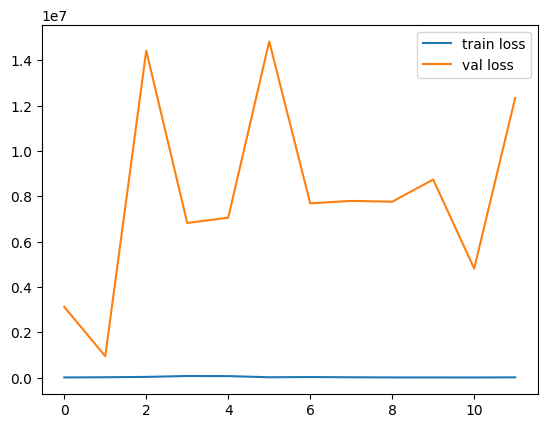

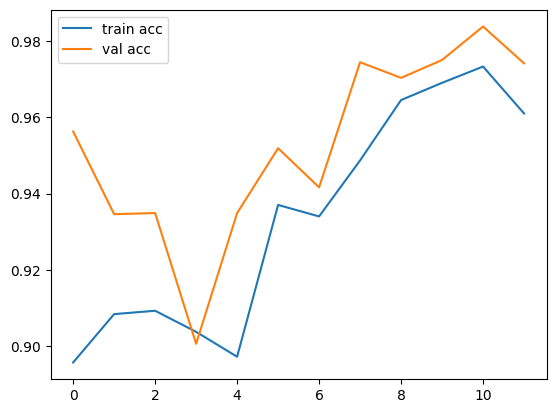

107/107 [==============================] - 8s 75ms/step


<Figure size 640x480 with 0 Axes>

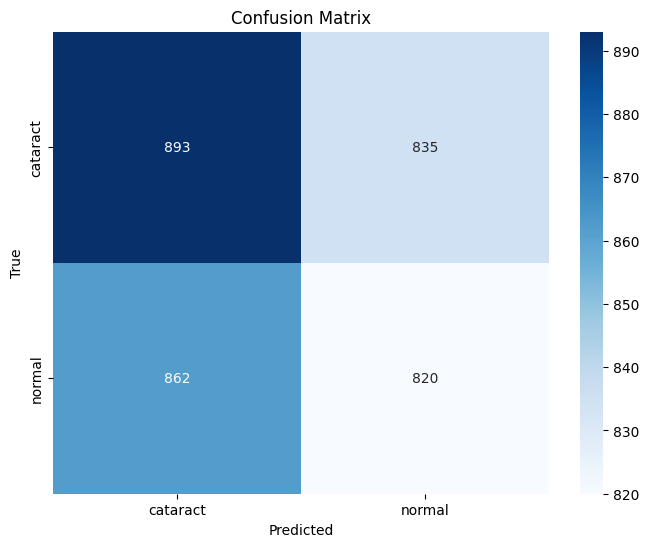

Classification Report:
               precision    recall  f1-score   support

    cataract       0.51      0.52      0.51      1728
      normal       0.50      0.49      0.49      1682

    accuracy                           0.50      3410
   macro avg       0.50      0.50      0.50      3410
weighted avg       0.50      0.50      0.50      3410

Class: cataract
  Accuracy: 0.50
  Precision: 0.51
  Recall: 0.52
  F1-Score: 0.51
Class: normal
  Accuracy: 0.50
  Precision: 0.50
  Recall: 0.49
  F1-Score: 0.49


<Figure size 640x480 with 0 Axes>

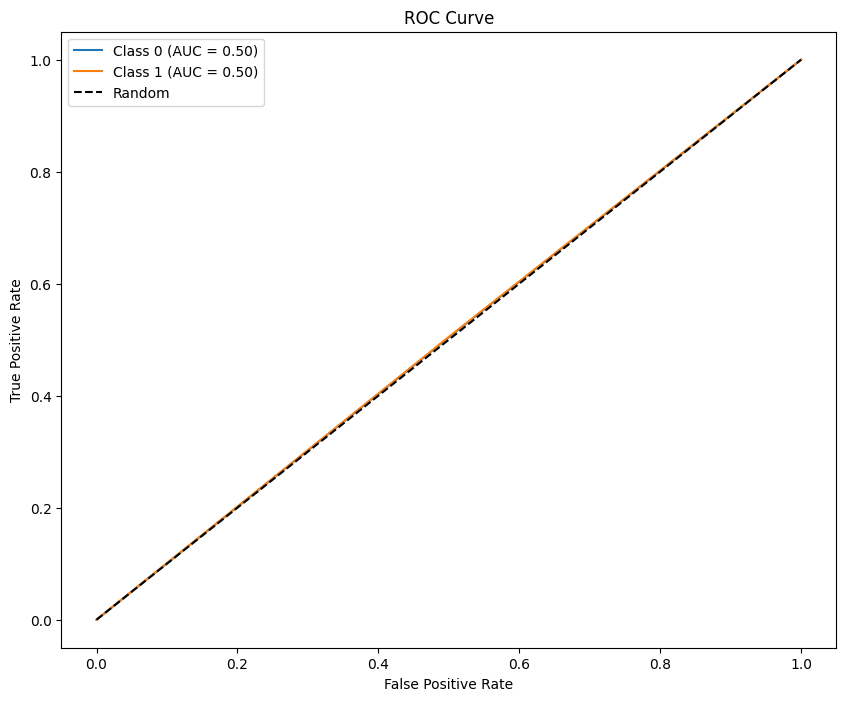

<Figure size 640x480 with 0 Axes>

In [9]:
# Definisikan path folder data training dan testing
train_data_dir = '/kaggle/working/output_splitting/train/'
test_data_dir = '/kaggle/working/output_splitting/test/'

# Definisikan parameter untuk pelatihan model
input_shape = (224, 224, 3)
batch_size = 32
epochs = 50
num_classes = 2

# test_datagen = ImageDataGenerator(rescale=1.0/255)

# Buat generator data pelatihan dan pengujian tanpa augmentasi
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],  # Sesuaikan dengan input_shape
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],  # Sesuaikan dengan input_shape
    batch_size=batch_size,
    class_mode='categorical'
)

# Create a VGG19 model
vgg = VGG19(input_shape=input_shape , weights='imagenet', include_top=False)

# # Unfreeze the last three blocks (15th to 17th blocks)
# for layer in vgg.layers[:-4]:
#     layer.trainable = False

# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False
    
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(num_classes,activation="sigmoid"))

model.summary()

# # Create a new model on top of VGG19
# model = Sequential()
# model.add(vgg)

# # Additional Convolutional Layers
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flatten and Fully Connected Layers
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()  

# # This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
# for layer in vgg.layers:
#   layer.trainable = False
    
# # Stacking a new simple convolutional network on top of it    
# x = Flatten()(vgg.output)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
# x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)
# x = Dense(num_classes, activation='softmax')(x)

# #Creating model object 
# model = Model(inputs=vgg.input, outputs=x)

# model.summary()

# # Define learning rate schedule function
# def lr_schedule(epoch):
#     initial_lr = 0.01
#     drop_factor = 0.5
#     epochs_drop = 10.0
#     min_lr = 1e-5
    
#     lr = initial_lr * math.pow(drop_factor, math.floor((1 + epoch) / epochs_drop))
#     return max(lr, min_lr)

# Define callbacks
checkpoint_vgg = ModelCheckpoint('model.save', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
log_dir = "logs/fit_vgg/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# lr_scheduler = LearningRateScheduler(lr_schedule)  # Learning Rate Scheduler callback

callbacks = [checkpoint_vgg, early_stopping_vgg, tensorboard_callback]

#Compile the model 
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
# adam_optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='categorical_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])
history = model.fit(train_generator,epochs=epochs,validation_data=test_generator,callbacks=callbacks)

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss.png")

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig("AccVal_acc.png")

# Load best model (model dengan val_accuracy terbaik) jika menggunakan ModelCheckpoint
model = load_model('model.save')

# Evaluasi model pada data uji
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.savefig("Confusion_Matrix.png")

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

# Calculate Accuracy, Precision, Recall, and F1-score from Confusion Matrix
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the values
for i, class_name in enumerate(test_generator.class_indices.keys()):
    print(f'Class: {class_name}')
    print(f'  Accuracy: {accuracy:.2f}')
    print(f'  Precision: {precision[i]:.2f}')
    print(f'  Recall: {recall[i]:.2f}')
    print(f'  F1-Score: {f1_score[i]:.2f}')

# ROC Curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=num_classes)[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
plt.savefig("ROC_Curve.png")

In [10]:
# # Load best model (model dengan val_accuracy terbaik) jika menggunakan ModelCheckpoint
# model = load_model('model.save')

# # Evaluasi model pada data uji
# y_true = test_generator.classes
# y_pred_probs = model.predict(test_generator)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Confusion Matrix
# conf_matrix = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()
# plt.savefig("Confusion_Matrix.png")

# # Classification Report
# class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
# print("Classification Report:\n", class_report)

# # Calculate Accuracy, Precision, Recall, and F1-score from Confusion Matrix
# accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
# precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
# recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
# f1_score = 2 * (precision * recall) / (precision + recall)

# # Print the values
# for i, class_name in enumerate(test_generator.class_indices.keys()):
#     print(f'Class: {class_name}')
#     print(f'  Accuracy: {accuracy:.2f}')
#     print(f'  Precision: {precision[i]:.2f}')
#     print(f'  Recall: {recall[i]:.2f}')
#     print(f'  F1-Score: {f1_score[i]:.2f}')

# # ROC Curve and AUC
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=num_classes)[:, i], y_pred_probs[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC Curve
# plt.figure(figsize=(10, 8))
# for i in range(num_classes):
#     plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# plt.plot([0, 1], [0, 1], 'k--', label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()
# plt.savefig("ROC_Curve.png")

In [11]:
# import zipfile
# import os
# from IPython.display import FileLink

# def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
#     os.chdir(directory)
#     zip_ref = zipfile.ZipFile(file_name, mode='w')
#     for folder, _, files in os.walk(directory):
#         for file in files:
#             if file_name in file:
#                 pass
#             else:
#                 zip_ref.write(os.path.join(folder, file))

#     return FileLink(file_name)

# zip_dir()